# Work with multiple samples (and coordinate systems)

In [1]:
%load_ext autoreload
%autoreload 2

Load libraries and create an empty spatialdata object that is backed by a zarr store.

In [2]:
import os

import tempfile
import uuid

from spatialdata import SpatialData

import sparrow as sp

sdata = SpatialData()

default_tmp_path = tempfile.gettempdir()

zarr_path = os.path.join( default_tmp_path, f"sdata_{uuid.uuid4()}.zarr")

sdata.write( zarr_path )

the value of the environment variable BASIC_DCT_BACKEND is not in ["JAX","SCIPY"]


INFO     The Zarr backing store has been changed from None the new file path:                                      
         /Users/arnedf/VIB/DATA/test_data/sdata_transformations.zarr                                               


Add image layers.

In [3]:
from dask_image import imread
from spatialdata.transformations import Identity

from sparrow.datasets.registry import get_registry

registry=get_registry()
arr_a1_1=imread.imread( registry.fetch( "transcriptomics/resolve/mouse/20272_slide1_A1-1_DAPI.tiff" ) )
arr_a1_2=imread.imread( registry.fetch( "transcriptomics/resolve/mouse/20272_slide1_A1-2_DAPI.tiff" ) )

sdata=sp.im.add_image_layer(
    sdata,
    arr=arr_a1_1,
    output_layer="image_a1_1",
    transformations={ "a1_1":  Identity() },
    overwrite=True,
 )

sdata=sp.im.add_image_layer(
    sdata,
    arr=arr_a1_2,
    output_layer="image_a1_2",
    transformations={ "a1_2":  Identity() },
    overwrite=True,
 )

2024-07-17 10:40:08,511 - sparrow.image._manager - WARNING - No dims parameter specified. Assuming order of dimension of provided array is ((c), (z), y, x)
2024-07-17 10:40:08,517 - sparrow.image._manager - INFO - Writing results to layer 'image_a1_1'
2024-07-17 10:40:09,176 - sparrow.image._manager - WARNING - No dims parameter specified. Assuming order of dimension of provided array is ((c), (z), y, x)
2024-07-17 10:40:09,180 - sparrow.image._manager - INFO - Writing results to layer 'image_a1_2'


Specify coordinate system when plotting

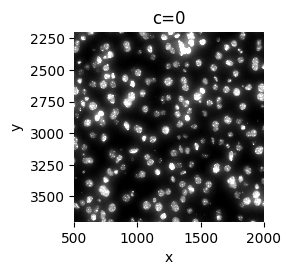

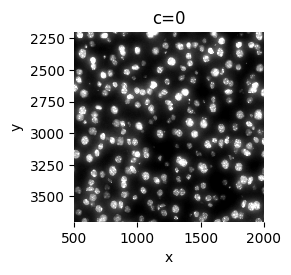

In [4]:
sp.pl.plot_image( sdata, img_layer="image_a1_1", to_coordinate_system="a1_1", crd=[500, 2000, 2200, 3700],figsize=(3,3))
sp.pl.plot_image( sdata, img_layer="image_a1_2", to_coordinate_system="a1_2", crd=[500, 2000, 2200, 3700],figsize=(3,3))

Do some image processing on full image, no need to specify a coordinate system

In [5]:
sdata=sp.im.min_max_filtering( sdata, img_layer="image_a1_1", output_layer="image_a1_1_min_max", size_min_max_filter=40, overwrite=True )

2024-07-17 10:40:10,282 - sparrow.image._apply - INFO - 'combine_z' is False, but not all 'z-slices' spefified in 'fn_kwargs'/'func' ({'size_min_max_filter': 40}/<function min_max_filtering.<locals>._apply_min_max_filter at 0x1069232e0>). Specifying z-slices ([0]).
2024-07-17 10:40:10,282 - sparrow.image._apply - INFO - 'combine_c' is False, but not all channels spefified in 'fn_kwargs'/'func' ({0: {'size_min_max_filter': 40}}/{0: <function min_max_filtering.<locals>._apply_min_max_filter at 0x1069232e0>}). Specifying channels ([0]).
2024-07-17 10:40:10,284 - sparrow.image._filters - WARNING - Provided value for min max filter size is even ('40'). To prevent unexpected output, we set min max filter to '41'.
2024-07-17 10:40:10,294 - sparrow.image._manager - WARNING - No dims parameter specified. Assuming order of dimension of provided array is ((c), (z), y, x)
2024-07-17 10:40:10,298 - sparrow.image._manager - INFO - Writing results to layer 'image_a1_1_min_max'


When doing some image processing on a crop, you need to specify the coordinate system to which the crop is defined

In [6]:
sdata=sp.im.min_max_filtering( sdata, img_layer="image_a1_1", output_layer="image_a1_1_min_max", size_min_max_filter=40, crd = [500, 2000, 2200, 3700], to_coordinate_system="a1_1", overwrite=True )
sdata=sp.im.min_max_filtering( sdata, img_layer="image_a1_2", output_layer="image_a1_2_min_max", size_min_max_filter=40, crd = [500, 2000, 2200, 3700], to_coordinate_system="a1_2", overwrite=True )

2024-07-17 10:40:15,562 - sparrow.image._apply - INFO - 'combine_z' is False, but not all 'z-slices' spefified in 'fn_kwargs'/'func' ({'size_min_max_filter': 40}/<function min_max_filtering.<locals>._apply_min_max_filter at 0x39d688670>). Specifying z-slices ([0]).
2024-07-17 10:40:15,563 - sparrow.image._apply - INFO - 'combine_c' is False, but not all channels spefified in 'fn_kwargs'/'func' ({0: {'size_min_max_filter': 40}}/{0: <function min_max_filtering.<locals>._apply_min_max_filter at 0x39d688670>}). Specifying channels ([0]).
2024-07-17 10:40:15,564 - sparrow.image._filters - WARNING - Provided value for min max filter size is even ('40'). To prevent unexpected output, we set min max filter to '41'.
2024-07-17 10:40:15,573 - sparrow.image._manager - WARNING - No dims parameter specified. Assuming order of dimension of provided array is ((c), (z), y, x)
2024-07-17 10:40:15,576 - sparrow.image._manager - INFO - Writing results to layer 'image_a1_1_min_max'
2024-07-17 10:40:15,900

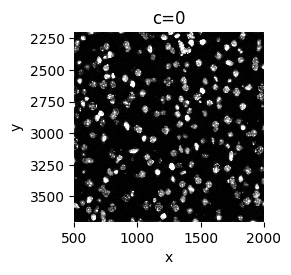

In [7]:
sp.pl.plot_image( sdata, img_layer="image_a1_1_min_max", to_coordinate_system="a1_1", figsize=(3,3), )

Now do segmentation

In [8]:
# no need to specify coordinate system if no crop is specifed
sdata = sp.im.segment(
    sdata,
    img_layer="image_a1_1_min_max",
    output_labels_layer="labels_a1_1",
    output_shapes_layer="shapes_a1_1",
    overwrite=True,
    crd=None,
)

# but need to specify to_coordinate_system when crop is defined

sdata = sp.im.segment(
    sdata,
    img_layer="image_a1_2_min_max",
    output_labels_layer="labels_a1_2",
    output_shapes_layer="shapes_a1_2",
    overwrite=True,
    crd=[600, 2000, 2200, 3700],
    to_coordinate_system="a1_2",
)

2024-07-17 10:40:21,945 - sparrow.image._manager - WARNING - No dims parameter specified. Assuming order of dimension of provided array is ((c), (z), y, x)
2024-07-17 10:40:21,948 - sparrow.image._manager - INFO - Writing results to layer 'labels_a1_1'
2024-07-17 10:40:29,241 - sparrow.image._manager - WARNING - No dims parameter specified. Assuming order of dimension of provided array is ((c), (z), y, x)
2024-07-17 10:40:29,244 - sparrow.image._manager - INFO - Writing results to layer 'labels_a1_2'


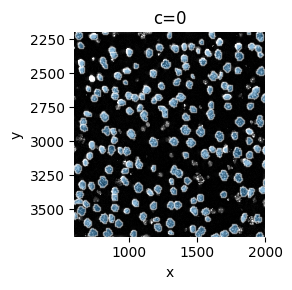

In [9]:
sp.pl.plot_shapes( sdata, img_layer="image_a1_2_min_max", shapes_layer="shapes_a1_2", to_coordinate_system="a1_2", crd=[ 600,2000,2200,3700 ], figsize=(3,3 ) )

Read the transcripts downloaded previously. Currently, the transformation specified on the transcripts is always the Identity transformation. The transcripts should be registered with the coordinate system of the image layer via an affine transform matrix that can be specified via the parameter `path_transform_matrix`. If not specified, the identity matrix will be used.

In [10]:
path_points_a1_1 = registry.fetch( "transcriptomics/resolve/mouse/20272_slide1_A1-1_results.txt" )
path_points_a1_2 = registry.fetch( "transcriptomics/resolve/mouse/20272_slide1_A1-2_results.txt" )

kwargs = {
    "column_x": 0,
    "column_y": 1,
    "column_gene": 3,
    "delimiter": "\t",
    "header": None,
    "overwrite": True,
}

sdata=sp.io.read_transcripts( sdata,
                             path_count_matrix=path_points_a1_1,
                             to_coordinate_system="a1_1",
                             output_layer="points_a1_1",
                             **kwargs )

sdata=sp.io.read_transcripts( sdata,
                             path_count_matrix=path_points_a1_2,
                             to_coordinate_system="a1_2",
                             output_layer="points_a1_2",
                             **kwargs )

2024-07-17 10:40:29,684 - sparrow.io._transcripts - INFO - No transform matrix given, will use identity matrix.
2024-07-17 10:40:29,684 - sparrow.io._transcripts - INFO - Transform matrix used:
 [[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
2024-07-17 10:40:30,908 - sparrow.io._transcripts - INFO - No transform matrix given, will use identity matrix.
2024-07-17 10:40:30,908 - sparrow.io._transcripts - INFO - Transform matrix used:
 [[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]


Verify that transformation associated to points layer is indeed the identity, and verify that shapes and labels have same transformation associated to them.

In [11]:
from spatialdata.transformations import get_transformation

print(  "points:\n", get_transformation( sdata[ "points_a1_2" ], get_all=True ))
print(  "image\n", get_transformation( sdata[ "image_a1_2_min_max"], get_all=True)) # one crop was taken, so one translation is defined on image.
print(  "labels:\n", get_transformation( sdata[ "labels_a1_2" ], get_all=True )) # two times a crop was taken, so a sequence of two translations is defined on labels/shapes.
print(  "shapes:\n",  get_transformation( sdata[ "shapes_a1_2" ], get_all=True )) # same transformation defined on associated shapes layer.

points:
 {'a1_2': Identity }
image
 {'a1_2': Sequence 
    Translation (c, y, x)
        [   0. 2200.  500.]
    Identity }
labels:
 {'a1_2': Sequence 
    Translation (y, x)
        [  0. 100.]
    Sequence 
        Translation (y, x)
            [2200.  500.]
        Identity }
shapes:
 {'a1_2': Sequence 
    Translation (x, y)
        [100.   0.]
    Sequence 
        Translation (x, y)
            [ 500. 2200.]
        Identity }


2024-07-17 10:40:32,132 - sparrow.plot._sanity - INFO - size before sampling is 93924
2024-07-17 10:40:32,289 - sparrow.plot._sanity - INFO - Plotting 10000 transcripts.
2024-07-17 10:40:32,290 - sparrow.plot._sanity - INFO - Selecting boundaries
2024-07-17 10:40:32,297 - sparrow.plot._sanity - INFO - Plotting boundaries
2024-07-17 10:40:32,331 - sparrow.plot._sanity - INFO - End plotting boundaries


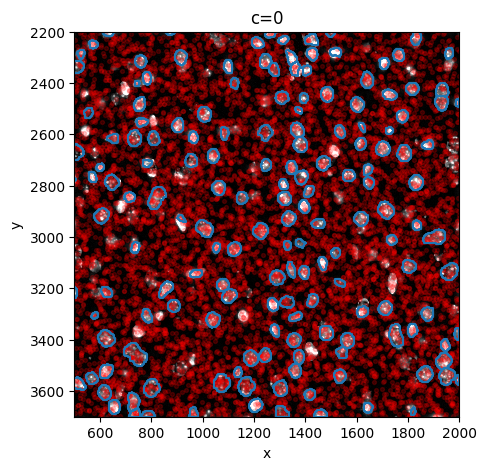

In [12]:
sp.pl.sanity_plot_transcripts_matrix( sdata, img_layer="image_a1_1_min_max", shapes_layer="shapes_a1_1", points_layer="points_a1_1", to_coordinate_system="a1_1", figsize=(5,5), n_sample=10000 )

2024-07-17 10:40:32,649 - sparrow.plot._sanity - INFO - size before sampling is 98247
2024-07-17 10:40:32,770 - sparrow.plot._sanity - INFO - Plotting 10000 transcripts.
2024-07-17 10:40:32,772 - sparrow.plot._sanity - INFO - Selecting boundaries
2024-07-17 10:40:32,780 - sparrow.plot._sanity - INFO - Plotting boundaries
2024-07-17 10:40:32,932 - sparrow.plot._sanity - INFO - End plotting boundaries


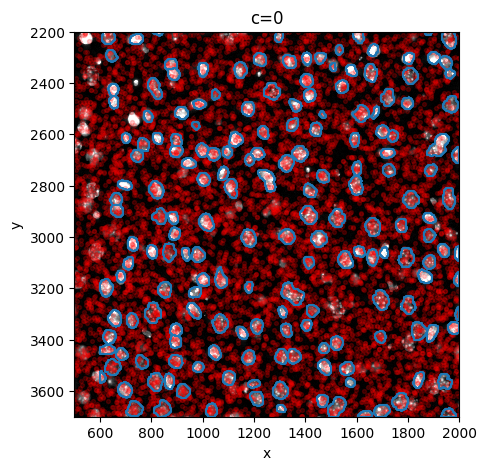

In [13]:
sp.pl.sanity_plot_transcripts_matrix( sdata, img_layer="image_a1_2_min_max", shapes_layer="shapes_a1_2", points_layer="points_a1_2", to_coordinate_system="a1_2", figsize=(5,5), n_sample=10000 )

In [14]:
sdata=sp.tb.allocate( sdata,
                     labels_layer="labels_a1_1",
                     points_layer="points_a1_1",
                     to_coordinate_system="a1_1",
                     output_layer="table",
                     append=False,
                     overwrite=True,
                       )

# append gene count of labels_a1_2 and points_a1_2 to anndata object with name 'table'
sdata=sp.tb.allocate( sdata,
                     labels_layer="labels_a1_2",
                     points_layer="points_a1_2",
                     to_coordinate_system="a1_2",
                     output_layer="table",
                     append=True,
                     overwrite=True,
                       )

2024-07-17 10:40:33,073 - sparrow.table._allocation - INFO - Calculating cell counts.
/Users/arnedf/miniconda3/envs/harpy/lib/python3.10/site-packages/anndata/_core/anndata.py:430: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/Users/arnedf/miniconda3/envs/harpy/lib/python3.10/site-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Users/arnedf/VIB/harpy/src/sparrow/table/_allocation.py:207: ImplicitModificationWarning: Setting element `.obsm['spatial']` of view, initializing view as actual.
  adata.obsm["spatial"] = coordinates[coordinates.index != "0"].values
2024-07-17 10:40:33,579 - sparrow.shape._manager - WARNING - No polygons filtered out for shapes layer 'shapes_a1_1'. As a result, shapes layer 'filtered_segmentation_shapes_a1_1' will not be created. This is expected if 'indexes_to_keep' matches 'shapes_a1

In [15]:
sdata = sp.tb.preprocess_transcriptomics(sdata, labels_layer=[ "labels_a1_1", "labels_a1_2" ], table_layer="table", output_layer="table_preprocessed", overwrite=True )  # we can also choose to set output_layer equal to 'table'.

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
2024-07-17 10:40:34,435 - sparrow.table._preprocess - INFO - Calculating cell size from provided labels_layer 'labels_a1_1'
2024-07-17 10:40:34,463 - sparrow.table._preprocess - INFO - Calculating cell size from provided labels_layer 'labels_a1_2'
/Users/arnedf/miniconda3/envs/harpy/lib/python3.10/site-packages/spatialdata/models/models.py:959: UserWarning: Converting `region_key: fov_labels` to categorical dtype.
  return convert_region_column_to_categorical(adata)
2024-07-17 10:40:35,008 - sparrow.shape._manager - INFO - Filtering 3 cells from shapes layer 'shapes_a1_1'. Adding new shapes layer 'filtered_low_counts_shapes_a1_1' containing these filtered out polygons.
2024-07-17 10:40:35,346 - sparrow.utils._io - WARNING - layer with name 'shapes_a1_1' already exists. Overwriting...
2024-07-17 10:40:35,550 - sparrow.shape._manager - INFO - Filtering 1 cells from shapes layer 'shapes_a1_2'.

In [16]:
sdata=sp.tb.filter_on_size( sdata, labels_layer=[ "labels_a1_1", "labels_a1_2" ], table_layer="table_preprocessed", output_layer="table_filtered", min_size=1000, overwrite=True )

2024-07-17 10:40:36,700 - sparrow.shape._manager - INFO - Filtering 28 cells from shapes layer 'shapes_a1_1'. Adding new shapes layer 'filtered_size_shapes_a1_1' containing these filtered out polygons.
2024-07-17 10:40:37,152 - sparrow.utils._io - WARNING - layer with name 'shapes_a1_1' already exists. Overwriting...
2024-07-17 10:40:37,440 - sparrow.shape._manager - INFO - Filtering 16 cells from shapes layer 'shapes_a1_2'. Adding new shapes layer 'filtered_size_shapes_a1_2' containing these filtered out polygons.
2024-07-17 10:40:37,899 - sparrow.utils._io - WARNING - layer with name 'shapes_a1_2' already exists. Overwriting...
2024-07-17 10:40:38,194 - sparrow.table._table - INFO - 44 cells were filtered out based on size.


In [17]:
sdata

SpatialData object, with associated Zarr store: /Users/arnedf/VIB/DATA/test_data/sdata_transformations.zarr
├── Images
│     ├── 'image_a1_1': DataArray[cyx] (1, 12864, 10720)
│     ├── 'image_a1_1_min_max': DataArray[cyx] (1, 1500, 1500)
│     ├── 'image_a1_2': DataArray[cyx] (1, 10720, 8576)
│     └── 'image_a1_2_min_max': DataArray[cyx] (1, 1500, 1500)
├── Labels
│     ├── 'labels_a1_1': DataArray[yx] (1500, 1500)
│     └── 'labels_a1_2': DataArray[yx] (1500, 1400)
├── Points
│     ├── 'points_a1_1': DataFrame with shape: (<Delayed>, 3) (2D points)
│     └── 'points_a1_2': DataFrame with shape: (<Delayed>, 3) (2D points)
├── Shapes
│     ├── 'filtered_low_counts_shapes_a1_1': GeoDataFrame shape: (3, 1) (2D shapes)
│     ├── 'filtered_low_counts_shapes_a1_2': GeoDataFrame shape: (1, 1) (2D shapes)
│     ├── 'filtered_size_shapes_a1_1': GeoDataFrame shape: (28, 1) (2D shapes)
│     ├── 'filtered_size_shapes_a1_2': GeoDataFrame shape: (16, 1) (2D shapes)
│     ├── 'shapes_a1_1': GeoDat

In [18]:
assert sdata[ "table_filtered" ].shape[0] == len( sdata[ "shapes_a1_1" ] ) + len(sdata[ "shapes_a1_2" ])

In [19]:
from sparrow.utils._keys import _REGION_KEY

for to_coordinate_system in [ "a1_1", "a1_2" ]:

    assert sdata[ "table" ][ sdata[ "table" ].obs[ _REGION_KEY ] == f"labels_{to_coordinate_system}"].shape[0] ==\
          len( sdata[ f"shapes_{to_coordinate_system}" ] ) + len( sdata[ f"filtered_low_counts_shapes_{to_coordinate_system}" ] ) + len( sdata[ f"filtered_size_shapes_{to_coordinate_system}" ] )

In [ ]:
zarr_path = os.path.join( default_tmp_path, f"sdata_{uuid.uuid4()}.zarr") # output path for queried sdata

labels_layer = ["labels_a1_1", "labels_a1_2", ]
crd = [(600, 1000, 2300, 3000), (700, 1000, 2300, 2500),  ]
to_coordinate_system = ["a1_1", "a1_2" ]

sdata_queried=sp.utils.bounding_box_query(
    sdata,
    labels_layer=labels_layer,
    crd = crd,
    to_coordinate_system=to_coordinate_system,
    copy_img_layer=False,
    copy_shapes_layer=False,
    copy_points_layer=False,
    output=zarr_path,
        )

for _labels_layer in labels_layer:
    assert _labels_layer in sdata_queried.labels